In [1]:
from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint as odeint_adj
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from random import sample
import time
import os
import copy

In [2]:
a = np.load('dataset/2d_shell.npy')
print(a.shape)

(20000, 101, 4)


# Training neural ODE

In [7]:
class ODEFunc(nn.Module):
    def __init__(self, twice_dim):
        super(ODEFunc, self).__init__()
        self.dim = twice_dim // 2
        
        self.net1 = nn.Sequential(
            nn.Linear(self.dim, 50),
            nn.ReLU(),
            nn.Linear(50,50),
            nn.ReLU(),
            nn.Linear(50, self.dim),   
        )
        
        for m in self.net1.modules():
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,mean=0,std=0.01)
                nn.init.constant_(m.bias,val=0)

        self.net2 = nn.Sequential(
            nn.Linear(self.dim, 50),
            nn.ReLU(),
            nn.Linear(50,50),
            nn.ReLU(),
            nn.Linear(50, self.dim),   
        )
        
        for m in self.net2.modules():
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,mean=0,std=0.01)
                nn.init.constant_(m.bias,val=0)
                                

        
    def forward(self, t, y):
        
#         print(y.shape)
#         print(y)
        q,p = torch.split(y, self.dim, dim=1)
        p_out = self.net1(q)
        q_out = self.net2(p)
        out = torch.cat((q_out, p_out), dim=1)
        #out = torch.ones(y.shape)
        #out[:,0] = y[:,2]
        #out[:,1] = y[:,3]
        #out[:,2] = y[:,0]/(0.6666**2)
        #out[:,3] = y[:,1]/(0.3333**2)
        
        return out


In [4]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.losses = []
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.log(val)
    
    def log(self, val):
        self.losses.append(val)


In [5]:
def GaussianXD(q, p):
    dim = q.shape[0]
    sigma = np.ones(dim)
    V = 0.5*np.sum(q**2 / (sigma**2))
    grad = q/(sigma**2)
    return V, grad

def Shell2D(q, p):
    r0 = np.sqrt(2)
    sigma = 0.5
    r = np.sqrt(np.dot(q, q))
    V = abs(r-r0)/sigma
    
    if (r-r0) == 0 or r == 0:
        grad = np.array([0, 0])
    else:
        grad = (q*(r-r0)/(sigma*r*abs(r-r0)))
        
    return V, grad

def Wofe_Quapp(q, p):
    x = q[0]
    y = q[1]
    V = x**4 + y**4 - 2*x**2 - 4*y**2 + x*y + 0.3*x + 0.1*y
    grad = np.array([4*x**3 - 4*x + y + 0.3, 4*y**3 - 8*y + x + 0.1])
    return V, grad

In [6]:
def get_batch_mod(traj,batch_size,batch_length,dt):
    
    twice_dim = traj.size()[2]
    sampled_is = torch.randint(traj.shape[0],size = (batch_size,))
    sampled_js = torch.randint(traj.shape[1]-batch_length,size = (batch_size,))
    initial_time = sampled_js*dt
    
    batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length)
    pos_init = traj[sampled_is,sampled_js,:].view(-1, twice_dim)
    
    sampled_trajs = []
    
    for i in range(batch_size):          
        sampled_trajs.append(traj[sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:].view(-1,twice_dim))
        
    batch_trajs = torch.stack(sampled_trajs,dim=1)
  
    return batch_t,pos_init,batch_trajs

In [151]:
# 2d Shell
training_trajs = torch.Tensor(np.load('2d_shell/trajs.npy'))
twice_dim = training_trajs.size()[2]
func = ODEFunc(twice_dim)

niters = 1000
optimizer = torch.optim.Adam(func.parameters(), lr=1e-2)
loss_meter = RunningAverageMeter()

nsample = 200
sampleLength = 10
dt = 0.01 

for itr in range(1, niters + 1):
    start = time.perf_counter()
    optimizer.zero_grad()

    batch_t, batch_y0, batch_y = get_batch_mod(training_trajs, nsample, sampleLength,dt)

    pred_y = odeint_adj(func, batch_y0, batch_t)

    loss = torch.mean(torch.abs(pred_y - batch_y) )
    loss.backward() 
    optimizer.step()
    loss_meter.update(loss.item())
    
    if itr % 10 == 0: # output log throughout
        print('Iter: {}, running avg elbo: {:.4f}'.format(itr, loss_meter.avg))
        print('current loss: {:.4f}'.format(loss_meter.val))
        print('Last iteration took: ', time.perf_counter() - start)
        
    if itr % 10 == 0: # do a validation step across entire trajectory
        for i in range(2):
            plt.plot(pred_y[:,i,1].detach().numpy(),pred_y[:,i,0].detach().numpy(),color='blue',alpha=0.5)
            plt.plot(batch_y[:,i,1].detach().numpy(),batch_y[:,i,0].detach().numpy(),color='red',alpha=0.5)
        plt.savefig('temp/{0}.png'.format(itr))
        plt.close()
        
torch.save(func, '2d_shell/model_constrained')    

Iter: 10, running avg elbo: 0.0448
current loss: 0.0401
Last iteration took:  0.35687397397123277
Iter: 20, running avg elbo: 0.0435
current loss: 0.0245
Last iteration took:  1.2085899820085615
Iter: 30, running avg elbo: 0.0416
current loss: 0.0221
Last iteration took:  0.9901458099484444
Iter: 40, running avg elbo: 0.0397
current loss: 0.0223
Last iteration took:  1.0911456380272284
Iter: 50, running avg elbo: 0.0380
current loss: 0.0202
Last iteration took:  1.1553219920024276
Iter: 60, running avg elbo: 0.0363
current loss: 0.0201
Last iteration took:  0.9971901359967887
Iter: 70, running avg elbo: 0.0347
current loss: 0.0187
Last iteration took:  1.1224200590513647
Iter: 80, running avg elbo: 0.0332
current loss: 0.0171
Last iteration took:  1.120585958007723
Iter: 90, running avg elbo: 0.0319
current loss: 0.0182
Last iteration took:  1.1288783320924267
Iter: 100, running avg elbo: 0.0307
current loss: 0.0205
Last iteration took:  1.1139920379500836
Iter: 110, running avg elbo: 

Iter: 860, running avg elbo: 0.0043
current loss: 0.0034
Last iteration took:  2.921445781015791
Iter: 870, running avg elbo: 0.0043
current loss: 0.0035
Last iteration took:  3.1632651300169528
Iter: 880, running avg elbo: 0.0042
current loss: 0.0039
Last iteration took:  3.773187556071207
Iter: 890, running avg elbo: 0.0042
current loss: 0.0034
Last iteration took:  3.1468710609478876
Iter: 900, running avg elbo: 0.0042
current loss: 0.0043
Last iteration took:  3.220266678952612
Iter: 910, running avg elbo: 0.0041
current loss: 0.0040
Last iteration took:  3.5670671940315515
Iter: 920, running avg elbo: 0.0041
current loss: 0.0033
Last iteration took:  3.1445097719551995
Iter: 930, running avg elbo: 0.0041
current loss: 0.0042
Last iteration took:  2.898945474997163
Iter: 940, running avg elbo: 0.0040
current loss: 0.0035
Last iteration took:  3.025787560036406
Iter: 950, running avg elbo: 0.0040
current loss: 0.0037
Last iteration took:  3.598248861031607
Iter: 960, running avg elb

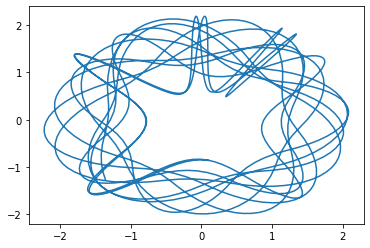

In [170]:
qs = [np.random.randn()*2 for i in range(twice_dim//2)]
ps = [np.random.randn()*0.7 for i in range(twice_dim//2)]
init = torch.tensor(qs+ps).reshape(1, -1)
dt = 0.1
batch_length = 1000
batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length)
pred_y = odeint_adj(func, init, batch_t)
plt.plot(pred_y[:, 0, 0].detach().numpy(),pred_y[:,0, 1].detach().numpy())
plt.show()

In [132]:
# Wofe Quapp
training_trajs = torch.Tensor(np.load('wofe_quapp/trajs.npy'))
twice_dim = training_trajs.size()[2]
func = ODEFunc(twice_dim)

niters = 1
optimizer = torch.optim.Adam(func.parameters(), lr=1e-2)
loss_meter = RunningAverageMeter()

nsample = 200
sampleLength = 10
dt = 0.1 

for itr in range(1, niters + 1):
    start = time.perf_counter()
    optimizer.zero_grad()

    batch_t, batch_y0, batch_y = get_batch_mod(training_trajs, nsample, sampleLength,dt)

    pred_y = odeint_adj(func, batch_y0, batch_t)

    loss = torch.mean(torch.abs(pred_y - batch_y) )
    loss.backward() 
    optimizer.step()
    loss_meter.update(loss.item())
    
    if itr % 10 == 0: # output log throughout
        print('Iter: {}, running avg elbo: {:.4f}'.format(itr, loss_meter.avg))
        print('current loss: {:.4f}'.format(loss_meter.val))
        print('Last iteration took: ', time.perf_counter() - start)
        
    if itr % 10 == 0: # do a validation step across entire trajectory
        for i in range(2):
            plt.plot(pred_y[:,i,1].detach().numpy(),pred_y[:,i,0].detach().numpy(),color='blue',alpha=0.5)
            plt.plot(batch_y[:,i,1].detach().numpy(),batch_y[:,i,0].detach().numpy(),color='red',alpha=0.5)
        plt.savefig('temp/{0}.png'.format(itr))
        plt.close()
        
torch.save(func, 'wofe_quapp/model_constrained')    

In [ ]:
# 10D Gaussian
training_trajs = torch.Tensor(np.load('10d_gaussian/trajs.npy'))
twice_dim = training_trajs.size()[2]
func = ODEFunc(twice_dim)

niters = 1000
optimizer = torch.optim.Adam(func.parameters(), lr=1e-2)
loss_meter = RunningAverageMeter()

nsample = 200
sampleLength = 10
dt = 0.1 

for itr in range(1, niters + 1):
    start = time.perf_counter()
    optimizer.zero_grad()

    batch_t, batch_y0, batch_y = get_batch_mod(training_trajs, nsample, sampleLength,dt)

    pred_y = odeint_adj(func, batch_y0, batch_t)

    loss = torch.mean(torch.abs(pred_y - batch_y) )
    loss.backward() 
    optimizer.step()
    loss_meter.update(loss.item())
    
    if itr % 10 == 0: # output log throughout
        print('Iter: {}, running avg elbo: {:.4f}'.format(itr, loss_meter.avg))
        print('current loss: {:.4f}'.format(loss_meter.val))
        print('Last iteration took: ', time.perf_counter() - start)
        
    if itr % 10 == 0: # do a validation step across entire trajectory
        for i in range(2):
            plt.plot(pred_y[:,i,1].detach().numpy(),pred_y[:,i,0].detach().numpy(),color='blue',alpha=0.5)
            plt.plot(batch_y[:,i,1].detach().numpy(),batch_y[:,i,0].detach().numpy(),color='red',alpha=0.5)
        plt.savefig('temp/{0}.png'.format(itr))
        plt.close()
        
torch.save(func, '10d_gaussian/model_constrained')    

# HMC with Neural ODE

In [6]:
class ODEFunc_exact_den(nn.Module):
    def __init__(self,ODE_model):
        super(ODEFunc_exact_den, self).__init__()
        self.net = ODE_model
        
    def forward(self, t, y):
#         start = time.time()
        #print("here")
        zero = torch.tensor([0.0]).view(-1,1) # what is this zero for?
        inp = torch.cat((zero,y[:,:-1]),dim=1)
        f = self.net(t,y[:,:-1])
        #print(time.time()-start)
        Jacobian = torch.autograd.functional.jacobian(self.net, (t,y[:,:-1]))
        #print(time.time()-start)
        # what is the Jacobian shape here and what is Jacobian[1] ?
        Tr = torch.trace(Jacobian[1].view(twice_dim,twice_dim)).view(-1,1)
        
        out = torch.cat((f,-Tr),dim=1)
        return out

In [7]:
def Evaluate_H(f, q,p,M_inv):
    V_o,grad = f(q,p)
    H_o = V_o + 0.5*( np.matmul(p.reshape(1,-1),np.matmul(M_inv,p.reshape(-1,1)))   )
    H_o = H_o.reshape(-1)
    return H_o

In [75]:
def Neural_dynamics(f,q_temp,p_temp,M,M_inv,steps,eps,store=True):
    dim = q_temp.shape[0]
    
    batch_t = torch.linspace(0.0,eps*(steps-1),steps)
    #print(batch_t.shape)
    
    q_temp = torch.tensor(q_temp)
    p_temp = torch.tensor(p_temp)
    Zero = torch.tensor([0.0])
    init = torch.cat((q_temp,p_temp,Zero),dim=0).float()
    init = init.view(1,-1)
    start = time.perf_counter()
    pred_y = odeint(func_mod, init, batch_t,method = 'rk4',options = dict(step_size=eps))
    print('odeint', time.perf_counter()-start)
    #print(pred_y.shape)
    
    
    pred_y = pred_y.detach().numpy()
    p_y = pred_y[:,0,:-1]
    J = pred_y[:,0,-1]
    
    energies = []
    
    for i in range(p_y.shape[0]):
        q = p_y[i,:dim]
        p = p_y[i,dim:]
        curr_e = Evaluate_H(f,q,p,M_inv)
    
        energies.append(curr_e)
    
    energies = np.asarray(energies)
    #print(energies.shape)
    #print(p_y.shape)
    return (p_y[-1,:dim],p_y[-1,dim:]),J[-1],p_y,energies



In [76]:
def Neural_HMC(f,q0,num_samples,eps,steps,store=False):
    
    samples = []
    accept_rate = 0
    q = q0
    
    if store == True:
        stored_vals = np.zeros((num_samples,steps,twice_dim))
        energies = np.zeros((num_samples,steps))
        
    ind = 0
    M = np.identity(twice_dim//2)
    M_inv = np.linalg.inv(M)
    while len(samples) < num_samples:
        
        ####### Need to fix
        mean = np.zeros((twice_dim//2))
        cov = M
        p = np.random.multivariate_normal(mean, cov)
        
        q_temp = copy.deepcopy(q)
        p_temp = copy.deepcopy(p)
        
        (q_f,p_f),J,path,energy = Neural_dynamics(f,q_temp,p_temp,M,M_inv,steps,eps,store=True)
        stored_vals[ind,:,:] = np.asarray(path)
        energies[ind,:] = np.asarray(energy).reshape(-1)
        
        p_f *= -1
        
        
        V_o,grad = f(q,p)
        V_f,grad = f(q_f,p_f)
        H_o = V_o + 0.5*np.matmul(p.reshape(1,-1),np.matmul(M_inv,p.reshape(-1,1)))
        H_o = H_o.reshape(-1)
        H_f = V_f + 0.5*np.matmul(p_f.reshape(1,-1),np.matmul(M_inv,p_f.reshape(-1,1)))
        H_f = H_f.reshape(-1)
        
        acceptance = (H_o - H_f) + J
        
        val = np.log(np.random.rand())
        #print(J.shape)
        #print(acceptance.shape)
        
        if val < acceptance:
            q = q_f
            accept_rate += 1
        
        samples.append(q)
        
        if len(samples)%500 == 0 and len(samples)< 2000:
            if len(samples) == 500:
                recent_samples = np.asarray(samples)
            else:
                recent_samples = np.asarray(samples[-500:])
            if (np.abs(np.linalg.det(np.cov(recent_samples.T))) > 0.001):
                M_inv = np.cov(recent_samples.T)
                M = np.linalg.inv(M_inv)
            else:
                M = np.identity(twice_dim//2)
                M_inv = np.linalg.inv(M)
#             print(M_inv)
        ind+=1
             
    acceptance = accept_rate/num_samples
        
    return samples,stored_vals,energies, acceptance

In [187]:
# Shell 2D
num_samples = [5000, 10000] 
twice_dim = 4
init = np.random.randn(twice_dim//2)*2
traj_length = 10
traj_step_size = 0.01
num_of_runs = 5
potential = '2d_shell'
potential_function = Shell2D
func = torch.load(f'{potential}/model_constrained')
func_mod = ODEFunc_exact_den(func)

for q in num_samples:
    for i in range(1, num_of_runs+1):
        start = time.perf_counter()
        samps,trajs,energies,acceptance = Neural_HMC(potential_function, init, q, traj_step_size, traj_length, store=True)

        if not os.path.exists(f'{potential}/neural_constrained_{q}'):
            os.makedirs(f'{potential}/neural_constrained_{q}')

        with open(f'{potential}/neural_constrained_{q}/{i}_hmc_samps.npy', 'wb') as f:
            np.save(f, samps)

        with open(f'{potential}/neural_constrained_{q}/{i}_info.npy', 'wb') as f:
            np.save(f, np.array([time.perf_counter() - start, acceptance]))
        print(q, i)


5000 1
5000 2
5000 3
5000 4
5000 5
10000 1
10000 2
10000 3
10000 4
10000 5


In [19]:
# Wofe-Quapp
num_samples = [100, 200, 500, 1000, 2000, 5000, 10000]
twice_dim = 4
init = np.random.randn(twice_dim//2)*2
traj_length = 10
traj_step_size = 0.1
num_of_runs = 5
potential = 'wofe_quapp'
potential_function = Wofe_Quapp
func = torch.load(f'{potential}/model_constrained')
func_mod = ODEFunc_exact_den(func)

for q in num_samples:
    for i in range(1, num_of_runs+1):
        start = time.perf_counter()
        samps,trajs,energies,acceptance = Neural_HMC(potential_function, init, q, traj_step_size, traj_length, store=True)

        if not os.path.exists(f'{potential}/neural_constrained_{q}'):
            os.makedirs(f'{potential}/neural_constrained_{q}')

        with open(f'{potential}/neural_constrained_{q}/{i}_hmc_samps.npy', 'wb') as f:
            np.save(f, samps)

        with open(f'{potential}/neural_constrained_{q}/{i}_info.npy', 'wb') as f:
            np.save(f, np.array([time.perf_counter() - start, acceptance]))
        print(q, i)


100 1
100 2
100 3
100 4
100 5
200 1
200 2
200 3
200 4
200 5
500 1
500 2
500 3
500 4
500 5
1000 1
1000 2
1000 3
1000 4
1000 5
2000 1
2000 2
2000 3
2000 4
2000 5
5000 1
5000 2
5000 3
5000 4
5000 5
10000 1
10000 2
10000 3
10000 4
10000 5


In [ ]:
# Gaussian 10D
num_samples = [100, 200, 500, 1000, 2000, 5000, 10000]
twice_dim = 20
init = np.random.randn(twice_dim//2)*2
traj_length = 10
traj_step_size = 0.1
num_of_runs = 5
potential = '10d_gaussian'
potential_function = GaussianXD
func = torch.load(f'{potential}/model_constrained')
func_mod = ODEFunc_exact_den(func)

for q in num_samples:
    for i in range(1, num_of_runs+1):
        start = time.perf_counter()
        samps,trajs,energies,acceptance = Neural_HMC(potential_function, init, q, traj_step_size, traj_length, store=True)

        if not os.path.exists(f'{potential}/neural_constrained_{q}'):
            os.makedirs(f'{potential}/neural_constrained_{q}')

        with open(f'{potential}/neural_constrained_{q}/{i}_hmc_samps.npy', 'wb') as f:
            np.save(f, samps)

        with open(f'{potential}/neural_constrained_{q}/{i}_info.npy', 'wb') as f:
            np.save(f, np.array([time.perf_counter() - start, acceptance]))
        print(q, i)


100 1
100 2
100 3
100 4
100 5
200 1
200 2
200 3
200 4
200 5
500 1
500 2
500 3
500 4
500 5
1000 1
1000 2
1000 3
1000 4
1000 5
2000 1
2000 2
2000 3
2000 4
2000 5
5000 1
5000 2
5000 3
5000 4
5000 5
10000 1
10000 2


In [77]:
# import torch.multiprocessing as mp
# torch.multiprocessing.set_start_method('spawn', force=True)
# import random
# import string
# import utils

# # Shell 2D
# num_samples = [100]
# twice_dim = 4
# init = np.random.randn(twice_dim//2)*2
# traj_length = 10
# traj_step_size = 0.01
# num_of_runs = 4
# potential = '2d_shell'
# potential_function = Shell2D
# func = torch.load(f'{potential}/model_constrained')
# func_mod = ODEFunc_exact_den(func)

# for q in num_samples:
#     start = time.perf_counter()

#     # Setup a list of processes that we want to run
#     args= (func_mod,twice_dim, potential_function, init, q, traj_step_size, traj_length, True)
# #         samps,trajs,energies,acceptance = Neural_HMC(potential_function, init, q, traj_step_size, traj_length, store=True)

#     pool = mp.Pool(processes=4)
#     results = [pool.apply_async(Neural_HMC, args=args) for x in range(num_of_runs)]
#     output = [p.get() for p in results]
    
#     for n in output:
#         samps,trajs,energies,acceptance = n
#         print(trajs[0])
#     print('PARALLEL TIME:', time.perf_counter() - start)


        
# #         if not os.path.exists(f'{potential}/neural_constrained_{q}'):
# #             os.makedirs(f'{potential}/neural_constrained_{q}')

# #         with open(f'{potential}/neural_constrained_{q}/{i}_hmc_samps.npy', 'wb') as f:
# #             np.save(f, samps)

# #         with open(f'{potential}/neural_constrained_{q}/{i}_info.npy', 'wb') as f:
# #             np.save(f, np.array([time.perf_counter() - start, acceptance]))
# #         print(q, i)

# Shell 2D
num_samples = [100] 
twice_dim = 4
init = np.random.randn(twice_dim//2)*2
traj_length = 10
traj_step_size = 0.01
num_of_runs = 5
potential = '2d_shell'
potential_function = Shell2D
func = torch.load(f'{potential}/model_constrained')
func_mod = ODEFunc_exact_den(func)


start = time.perf_counter()
for q in num_samples:
    for i in range(1, num_of_runs+1):
        start = time.perf_counter()
        samps,trajs,energies,acceptance = Neural_HMC(potential_function, init, q, traj_step_size, traj_length, store=True)
        print('total', time.perf_counter() - start)
        print(q, i)
        
print('SERIAL TIME:', time.perf_counter() - start)


odeint 0.04121324699372053
odeint 0.04025293607264757
odeint 0.04008002299815416
odeint 0.04006847203709185
odeint 0.03999265911988914
odeint 0.040413856972008944
odeint 0.040062869898974895
odeint 0.039923026924952865
odeint 0.039909993996843696
odeint 0.03991480707190931
odeint 0.04013687092810869
odeint 0.03980077407322824
odeint 0.040020385989919305
odeint 0.03990751807577908
odeint 0.039881173986941576
odeint 0.04014936601743102
odeint 0.039770235773175955
odeint 0.039928004844114184
odeint 0.03980015008710325
odeint 0.039895376889035106
odeint 0.04026120784692466
odeint 0.039848812855780125
odeint 0.039901972049847245
odeint 0.039856174029409885
odeint 0.039874443085864186
odeint 0.04022930609062314
odeint 0.039942068979144096
odeint 0.03984400816261768
odeint 0.039842542028054595
odeint 0.0398054919205606
odeint 0.0401570089161396
odeint 0.0398581528570503
odeint 0.039920730981975794
odeint 0.03985562198795378
odeint 0.03992959996685386
odeint 0.040083302184939384
odeint 0.03999

odeint 0.03884131205268204
total 3.954947784077376
100 3
odeint 0.03810553881339729
odeint 0.03836493706330657
odeint 0.03829900687560439
odeint 0.038362015038728714
odeint 0.03847327898256481
odeint 0.038607215974479914
odeint 0.03839092398993671
odeint 0.03858828614465892
odeint 0.0385779261123389
odeint 0.038723413832485676
odeint 0.038575923070311546
odeint 0.03869369300082326
odeint 0.03841498005203903
odeint 0.03836976480670273
odeint 0.0385965290479362
odeint 0.03838128596544266
odeint 0.0384104719851166
odeint 0.038793405052274466
odeint 0.038642814848572016
odeint 0.038318326929584146
odeint 0.038344420958310366
odeint 0.03868365008383989
odeint 0.038364476058632135
odeint 0.038636333076283336
odeint 0.038248944794759154
odeint 0.038478706032037735
odeint 0.038229481084272265
odeint 0.038387679029256105
odeint 0.038586059119552374
odeint 0.03873963304795325
odeint 0.03832056699320674
odeint 0.03842801507562399
odeint 0.03851452306844294
odeint 0.0385214111302048
odeint 0.03848

tensor([ 0.0000,  0.0000, -0.5296,  1.1842])
torch.Size([100, 4])


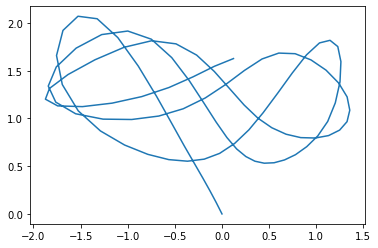

In [8]:
class ODEFunc(nn.Module):
    def __init__(self, twice_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(twice_dim, 50),
            nn.ReLU(),
            nn.Linear(50,50),
            nn.ReLU(),
            nn.Linear(50, twice_dim),
            
        )
        for m in self.net.modules():
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,mean=0,std=0.01)
                nn.init.constant_(m.bias,val=0)
        
    def forward(self, t, y):
        
        #print(y.shape)
        out = self.net(y)
        #out = torch.ones(y.shape)
        #out[:,0] = y[:,2]
        #out[:,1] = y[:,3]
        #out[:,2] = y[:,0]/(0.6666**2)
        #out[:,3] = y[:,1]/(0.3333**2)
        
        return out


func = torch.load('wofe_quapp/model')
qs = [0 for i in range(twice_dim//2)]
ps = [np.random.randn()*0.7 for i in range(twice_dim//2)]
init = torch.tensor(qs+ps)
print(init)

dt = 0.1
batch_length = 100
batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length)
pred_y = odeint_adj(func, init, batch_t)
print(pred_y.shape)

plt.plot(pred_y[:,0].detach().numpy(),pred_y[:,1].detach().numpy())
plt.show()

In [46]:
class ODEFunc(nn.Module):
    def __init__(self, twice_dim):
        super(ODEFunc, self).__init__()
        self.dim = twice_dim // 2
        
        self.net1 = nn.Sequential(
            nn.Linear(self.dim, 25),
            nn.ReLU(),
            nn.Linear(25,25),
            nn.ReLU(),
            nn.Linear(25, self.dim),   
        )
        
        for m in self.net1.modules():
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,mean=0,std=0.01)
                nn.init.constant_(m.bias,val=0)

        self.net2 = nn.Sequential(
            nn.Linear(self.dim, 25),
            nn.ReLU(),
            nn.Linear(25,25),
            nn.ReLU(),
            nn.Linear(25, self.dim),   
        )
        
        for m in self.net2.modules():
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,mean=0,std=0.01)
                nn.init.constant_(m.bias,val=0)
                                

        
    def forward(self, t, y):
        
#         print(y.shape)
#         print(y)
        q,p = torch.split(y, self.dim, dim=1)
        p_out = self.net1(q)
        q_out = self.net2(p)
        out = torch.cat((q_out, p_out), dim=1)
        #out = torch.ones(y.shape)
        #out[:,0] = y[:,2]
        #out[:,1] = y[:,3]
        #out[:,2] = y[:,0]/(0.6666**2)
        #out[:,3] = y[:,1]/(0.3333**2)
        
        return out


func = torch.load('wofe_quapp/model_constrained_halved')
init = init.view(1, -1)
print(init)

dt = 0.1
batch_length = 100
batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length)
pred_y = odeint_adj(func, init, batch_t)
print(pred_y.shape)

plt.plot(pred_y[:,0,0].detach().numpy(),pred_y[:,0,1].detach().numpy())
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'wofe_quapp/model_constrained_halved'

In [116]:
func = torch.load('2d_shell/model_constrained')
qs = [0 for i in range(twice_dim//2)]
ps = [np.random.randn()*0.7 for i in range(twice_dim//2)]
init = torch.tensor(qs+ps)
init = init.view(1, -1)
print(init)

dt = 0.01
batch_length = 10
batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length)
start = time.perf_counter()
for i in range(1):
    pred_y = odeint_adj(func, init, batch_t,method = 'rk4',options = dict(step_size=dt))
print(pred_y[:10, 0, :])
print(time.perf_counter() - start)

tensor([[0.0000, 0.0000, 0.6116, 0.2629]])
tensor([[0.0000, 0.0000, 0.6116, 0.2629],
        [0.0059, 0.0027, 0.6086, 0.2613],
        [0.0117, 0.0053, 0.6057, 0.2597],
        [0.0175, 0.0079, 0.6030, 0.2581],
        [0.0233, 0.0106, 0.6004, 0.2567],
        [0.0290, 0.0132, 0.5979, 0.2552],
        [0.0348, 0.0157, 0.5957, 0.2539],
        [0.0405, 0.0183, 0.5935, 0.2525],
        [0.0462, 0.0209, 0.5915, 0.2513],
        [0.0518, 0.0234, 0.5897, 0.2501]], grad_fn=<SliceBackward0>)
0.006069147028028965


In [123]:
func = torch.load('2d_shell/model_constrained')
# qs = [0 for i in range(twice_dim//2)]
# ps = [np.random.randn()*0.7 for i in range(twice_dim//2)]
# init = torch.tensor(qs+ps)
# init = init.view(1, -1)
# print(init)
# init = init.view(1, -1)
init = torch.Tensor(np.random.rand(1000, 4))

dt = 0.01
batch_length = 10
batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length)
start = time.perf_counter()
pred_y = odeint_adj(func, init, batch_t,method = 'rk4',options = dict(step_size=dt))
print(pred_y[:10, 0, :])
print(pred_y[:10, 5, :])
print(time.perf_counter() - start)

tensor([[0.9519, 0.0250, 0.0183, 0.5991],
        [0.9520, 0.0310, 0.0368, 0.5989],
        [0.9522, 0.0370, 0.0553, 0.5988],
        [0.9527, 0.0430, 0.0738, 0.5988],
        [0.9533, 0.0489, 0.0923, 0.5990],
        [0.9542, 0.0549, 0.1107, 0.5993],
        [0.9552, 0.0609, 0.1292, 0.5997],
        [0.9564, 0.0669, 0.1476, 0.6002],
        [0.9577, 0.0730, 0.1661, 0.6009],
        [0.9593, 0.0790, 0.1845, 0.6017]], grad_fn=<SliceBackward0>)
tensor([[0.3437, 0.3776, 0.6176, 0.5134],
        [0.3496, 0.3828, 0.6223, 0.5198],
        [0.3556, 0.3880, 0.6272, 0.5264],
        [0.3617, 0.3933, 0.6323, 0.5330],
        [0.3678, 0.3987, 0.6374, 0.5397],
        [0.3740, 0.4042, 0.6427, 0.5466],
        [0.3802, 0.4097, 0.6482, 0.5536],
        [0.3865, 0.4153, 0.6538, 0.5607],
        [0.3928, 0.4209, 0.6596, 0.5679],
        [0.3992, 0.4266, 0.6655, 0.5752]], grad_fn=<SliceBackward0>)
0.02515934011898935


In [89]:
print(pred_y[:10, 5, :])

tensor([[ 0.0000,  0.0000, -0.3371,  1.5841],
        [-0.0036,  0.0157, -0.3403,  1.5826],
        [-0.0072,  0.0314, -0.3436,  1.5814],
        [-0.0109,  0.0471, -0.3471,  1.5806],
        [-0.0146,  0.0628, -0.3508,  1.5802],
        [-0.0183,  0.0785, -0.3546,  1.5800],
        [-0.0221,  0.0942, -0.3586,  1.5803],
        [-0.0259,  0.1099, -0.3627,  1.5808],
        [-0.0298,  0.1256, -0.3670,  1.5817],
        [-0.0337,  0.1414, -0.3715,  1.5830]], grad_fn=<SliceBackward0>)


In [18]:
class ODEFunc(nn.Module):
    def __init__(self, twice_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(twice_dim, 50),
            nn.ReLU(),
            nn.Linear(50,50),
            nn.ReLU(),
            nn.Linear(50, twice_dim),
            
        )
        for m in self.net.modules():
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,mean=0,std=0.01)
                nn.init.constant_(m.bias,val=0)
        
    def forward(self, t, y):
        
#         print(y.shape)
        out = self.net(y)
        #out = torch.ones(y.shape)
        #out[:,0] = y[:,2]
        #out[:,1] = y[:,3]
        #out[:,2] = y[:,0]/(0.6666**2)
        #out[:,3] = y[:,1]/(0.3333**2)
#         print(out.shape)
        return out

func = torch.load('10d_gaussian/model')
distances = []
for i in range(10000):
    if (i % 100) == 0:
        print(i)
    twice_dim = 20
    qs = [np.random.rand()*0.7 for i in range(twice_dim//2)]
    ps = [np.random.randn()*0.7 for i in range(twice_dim//2)]
    init = torch.tensor(qs+ps)
    init = init.view(1, -1)
    
    dt = 0.1
    batch_length = 100
    batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length)
    pred_y = odeint_adj(func, init, batch_t,method = 'rk4',options = dict(step_size=dt))
    pred_y = pred_y.detach().numpy()
    # plt.plot(pred_y[:, 0, 0], pred_y[:, 0, 1])

    init = pred_y[-1,0,:]
    last = np.copy(init[:twice_dim//2])
    # print(init)
    init[twice_dim//2:] = -1 * init[twice_dim//2:]
    init = torch.tensor(init)
    init = init.view(1, -1)
    # print(init)

    pred_y = odeint_adj(func, init, batch_t,method = 'rk4',options = dict(step_size=dt))
    pred_y = pred_y.detach().numpy()
    first = np.copy(pred_y[-1,0,:twice_dim//2])
    # plt.plot(pred_y[:, 0, 0], pred_y[:, 0, 1])
    dist = np.linalg.norm(first-last)
    distances.append(dist)
print(np.mean(distances))


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
2.5190544


# Trainset Dataset Size (Toy Potentials)

In [24]:
from diffmd.solvers import odeint_adjoint
from diffmd.utils import compute_grad
from training import ODEFunc
from testing import get_first_batch

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import shutil
import csv

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(f'Using {device} device')


def get_first_batch(training_trajs,nsample,sampleLength,dt):
    twice_dim = training_trajs.size()[2]
    dim = twice_dim//2

    q0 = training_trajs[0:nsample, 0, :dim].to(device)
    p0 = training_trajs[0:nsample, 0, dim:].to(device)
    batch_y0 = (p0, q0)
    
    q = training_trajs[0:nsample, 0:sampleLength, :dim].to(device)
    p = training_trajs[0:nsample, 0:sampleLength, dim:].to(device)
    batch_y = torch.cat((p, q), dim=2).swapaxes(0, 1)
    
    batch_t = torch.linspace(0.0,dt*(sampleLength-1),sampleLength).to(device)
    return batch_t, batch_y0, batch_y


Using cpu device


In [23]:
potentials = ['10d_gaussian', '2d_shell', 'wofe_quapp']
batch_size = 5000
sample_length = 100

train_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 20000] # 2000
num_models = 5

for potential in potentials:
    if potential == '2d_shell':
        dt = 0.01
    else:
        dt = 0.1

    data = []
    for t in train_sizes:
        testing_trajs = torch.Tensor(np.load(f'dataset/{potential}_test.npy'))
        losses = []
        for i in range(1, num_models+1):
            func = torch.load(f'results/{potential}/train_size/{t}/{i}_model.pt', map_location=device).to(device)

            batch_t, batch_y0, batch_y = get_first_batch(testing_trajs, batch_size, sample_length,dt)
            
            batch_y0 = (batch_y0[0] / func.mass, batch_y0[1])
            pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

            # convert velocity to momentum (p = mu * v)
            pred_y = (pred_y[0] * func.mass, pred_y[1])
            pred_y = torch.cat(pred_y, dim=2)
            
            loss = torch.mean(torch.abs(pred_y - batch_y))
            losses.append(loss.item())

        data.append([t, np.mean(losses), np.std(losses)])
    data = np.array(data)

    print(data)

    np.save(f'results/{potential}/train_size/train_size_test_loss.npy', data)
        



torch.Size([5000, 101, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([5000, 101, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([5000, 101, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([5000, 101, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([5000, 101, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([5000, 101, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 5000, 20])
torch.Size([100, 500

# Divergence Loss (Triatomic)

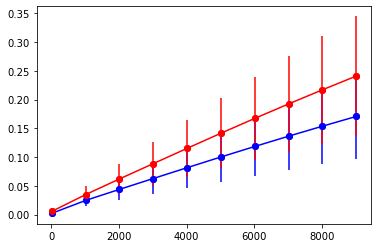

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def x(v_0, x_0, t):
    k = 1.0
    m = 0.5
    w_0 = np.sqrt(k/m)
    v_0 = v_0.reshape(-1, 1)
    x_0 = x_0.reshape(-1, 1)
    t = t.reshape(1, -1)
    return v_0 / w_0 * np.sin(w_0 * t) + x_0 * np.cos(w_0 * t)

def v(v_0, x_0, t):
    k = 1.0
    m = 0.5
    w_0 = np.sqrt(k/m)
    v_0 = v_0.reshape(-1, 1)
    x_0 = x_0.reshape(-1, 1)
    t = t.reshape(1, -1)
    return v_0 * np.cos(w_0 * t) - w_0 * x_0 * np.sin(w_0 * t)


data = np.load('results/spring/diatomic_data.npy')
data = np.swapaxes(data, 0, 1)

dt = 0.1

# niters = 8000
# plt.plot(data[0, :niters, 1])
# x_0 = data[0, 0, 1]
# v_0 = data[0, 0, 0]
# t = np.arange(dt, niters*dt+dt, dt)
# plt.plot(x(v_0, x_0, t))
# plt.xlim(niters-10, niters)
# plt.show()

means_x = []
stds_x = []

means_v = []
stds_v = []

traj_lengths = list(range(10, 10001, 1000))
for i, l in enumerate(traj_lengths):
    # truth at time l
    t = np.arange(1, l+1) / 10
    x_true = x(data[:, 0, 0], data[:, 0, 1], t)
    v_true = v(data[:, 0, 0], data[:, 0, 1], t)

    # abs difference
    diff_x = np.mean(np.abs(data[:, 1:l+1, 1] - x_true), axis=-1)
    diff_v = np.mean(np.abs(data[:, 1:l+1, 0] - v_true), axis=-1)
   
    # mean across samples
    mean_x = np.mean(diff_x, axis=0)
    mean_v = np.mean(diff_v, axis=0)
    std_x = np.std(diff_x, axis=0)
    std_v = np.std(diff_v, axis=0)
    
    means_x.append(mean_x)
    stds_x.append(std_x)
    means_v.append(mean_v)
    stds_v.append(std_v)



plt.plot(traj_lengths, means_x, 'bo-')
plt.plot(traj_lengths, means_v, 'ro-')
plt.errorbar(traj_lengths, means_x, stds_x, fmt='bo')
plt.errorbar(traj_lengths, means_v, stds_v, fmt='ro')

plt.show()

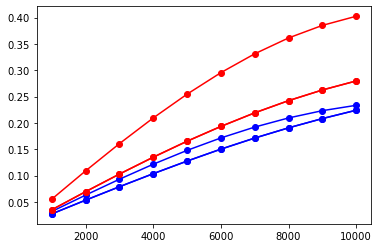

In [53]:
data_true = np.load('results/spring/data_explicit.npy')
data_model = np.load('results/spring/data_model.npy')

dt = 0.1

means_x = []
stds_x = []

means_v = []
stds_v = []

traj_lengths = list(range(1000, 10001, 1000))


for i, l in enumerate(traj_lengths):
    
    # abs difference
    diff_x = np.mean(np.abs(data_model[:, 1:l+1, :, 1] - data_true[:, 1:l+1, :, 1]), axis=1)
    diff_v = np.mean(np.abs(data_model[:, 1:l+1, :, 0] - data_true[:, 1:l+1, :, 0]), axis=1)

    
    # mean across samples
    mean_x = np.mean(diff_x, axis=0)
    mean_v = np.mean(diff_v, axis=0)
    std_x = np.std(diff_x, axis=0)
    std_v = np.std(diff_v, axis=0)
    
    means_x.append(mean_x)
    stds_x.append(std_x)
    means_v.append(mean_v)
    stds_v.append(std_v)



plt.plot(traj_lengths, means_x, 'bo-')
plt.plot(traj_lengths, means_v, 'ro-')
# plt.errorbar(traj_lengths, means_x, stds_x, fmt='bo')
# plt.errorbar(traj_lengths, means_v, stds_v, fmt='ro')

plt.show()

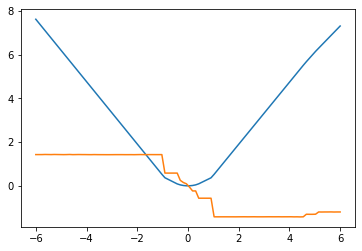

In [64]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
device = 'cpu'
class ODEFunc(nn.Module):
    def __init__(self, dim, width, depth):
        super(ODEFunc, self).__init__()
        self.dim = dim
        
        layers = []
        for i in range(depth):
            if i == 0:
                layers += [nn.Linear(self.dim, width), nn.Sigmoid()]
            if i == (depth-1):
                # TODO: is the last layer of a width 1?
                layers += [nn.Linear(width, self.dim)]
            else:
                layers += [nn.Linear(width, width), nn.Sigmoid()]
        self.net = nn.Sequential(*layers)
        
        for m in self.net.modules():
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,mean=0,std=0.01)
                nn.init.constant_(m.bias,val=0)


        # HACK
        m = 1.0
        self.mass = m*m/(m+m)

    def forward(self, state):
        
        with torch.set_grad_enabled(True):        
            
            v = state[0]
            q = state[1]
            
            q.requires_grad = True
            
            f = -self.compute_grad(q, 0.01)
            
            dvdt = f / self.mass
            dqdt = v
            
        return (dvdt, dqdt)

    def compute_grad(self, q, dq):
        # using this over compute_grad from nff seems to make no difference
        # HACK: does this only work with q_n => n=1? 
        # HACK: Is this wrong? Why is my NN output two values?
        return (self.net(q+dq) - self.net(q-dq)) / (2 * dq)

with torch.no_grad():
    func = torch.load(f'results/spring/diatomic_model_verlet').to(device)
    x = torch.linspace(-6, 6, 100).to(device).view(-1, 1)
    V = func.net(x)
    V -= V.min()

    F = -func.compute_grad(x, 0.0001)

    plt.plot(x.cpu().numpy(), V.cpu().numpy())
    plt.plot(x.cpu().numpy(), F.cpu().numpy())

# What to Learn On? (Toy Potentials)


In [1]:
from diffmd.solvers import odeint_adjoint
from diffmd.utils import compute_grad
from training import ODEFunc
from testing import get_first_batch

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import shutil
import csv

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(f'Using {device} device')


def get_first_batch(training_trajs,nsample,sampleLength,dt):
    twice_dim = training_trajs.size()[2]
    dim = twice_dim//2

    q0 = training_trajs[0:nsample, 0, :dim].to(device)
    p0 = training_trajs[0:nsample, 0, dim:].to(device)
    batch_y0 = (p0, q0)
    
    q = training_trajs[0:nsample, 0:sampleLength, :dim].to(device)
    p = training_trajs[0:nsample, 0:sampleLength, dim:].to(device)
    batch_y = torch.cat((p, q), dim=2).swapaxes(0, 1)
    
    batch_t = torch.linspace(0.0,dt*(sampleLength-1),sampleLength).to(device)
    return batch_t, batch_y0, batch_y


potentials = ['10d_gaussian', '2d_shell', 'wofe_quapp']
batch_size = 5000
sample_length = 100

loss_fces = ['all', 'vel', 'pos'] # 2000
num_models = 5

for potential in potentials:
    if potential == '2d_shell':
        dt = 0.01
    else:
        dt = 0.1

    data = []
    for l in loss_fces:
        testing_trajs = torch.Tensor(np.load(f'dataset/{potential}_test.npy'))
        losses = []
        for i in range(1, num_models+1):
            
            if potential == 'wofe_quapp':
                if l == 'vel' and i == 4:
                    continue
                if l == 'all' and i == 1:
                    continue
                

            func = torch.load(f'results/{potential}/loss_fce/{l}_{i}_model.pt', map_location=device).to(device)

            batch_t, batch_y0, batch_y = get_first_batch(testing_trajs, batch_size, sample_length,dt)
            
            batch_y0 = (batch_y0[0] / func.mass, batch_y0[1])
            pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

            # convert velocity to momentum (p = mu * v)
            pred_y = (pred_y[0] * func.mass, pred_y[1])
            pred_y = torch.cat(pred_y, dim=2)
            
            loss = torch.mean(torch.abs(pred_y - batch_y))
            losses.append(loss.item())

        data.append([l, np.mean(losses), np.std(losses)])
    data = np.array(data)

    print(data)

    np.save(f'results/{potential}/loss_fce/test_loss.npy', data)
        




c:\Users\jakub\anaconda3\envs\neuralode\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cpu device
Using cuda:1 device
Using cpu device
[['all' '0.02323340214788914' '0.0021875281639950396']
 ['vel' '0.022170927748084067' '0.00294876542758658']
 ['pos' '0.027394549921154976' '0.0036464330804922914']]
[['all' '0.28198155760765076' '8.941468364476818e-05']
 ['vel' '0.28479031324386594' '0.00033395793938079365']
 ['pos' '0.3105808436870575' '0.006654534756849675']]
[['all' '0.12123763374984264' '0.01693667100137244']
 ['vel' '0.18427065387368202' '0.06048829260071318']
 ['pos' '0.12252756655216217' '0.021295795847388513']]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
a = np.load(f'dataset/spring.npy')

x = a[:, :, 1]
x = x.reshape(-1, 1)

import seaborn as sns
sns.distplot(a=x, bins=100, color='purple',
             hist_kws={"edgecolor": 'black'})
plt.show()
# import scipy.stats as st

# plt.hist(x, density=True, bins=82, label="Data")
# mn, mx = plt.xlim()
# plt.xlim(mn, mx)
# kde_xs = np.linspace(mn, mx, 300)
# kde = st.gaussian_kde(x)
# plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
# plt.legend(loc="upper left")
# plt.ylabel("Probability")
# plt.xlabel("Data")
# plt.title("Histogram");
# plt.show()

/home/jakub/anaconda3/lib/python3.9/site-packages/scipy/stats/kde.py:565: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,


MemoryError: Unable to allocate 29.7 TiB for an array with shape (2020000, 2020000) and data type float64

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10. ]
[-0.35712408 -0.45910452]


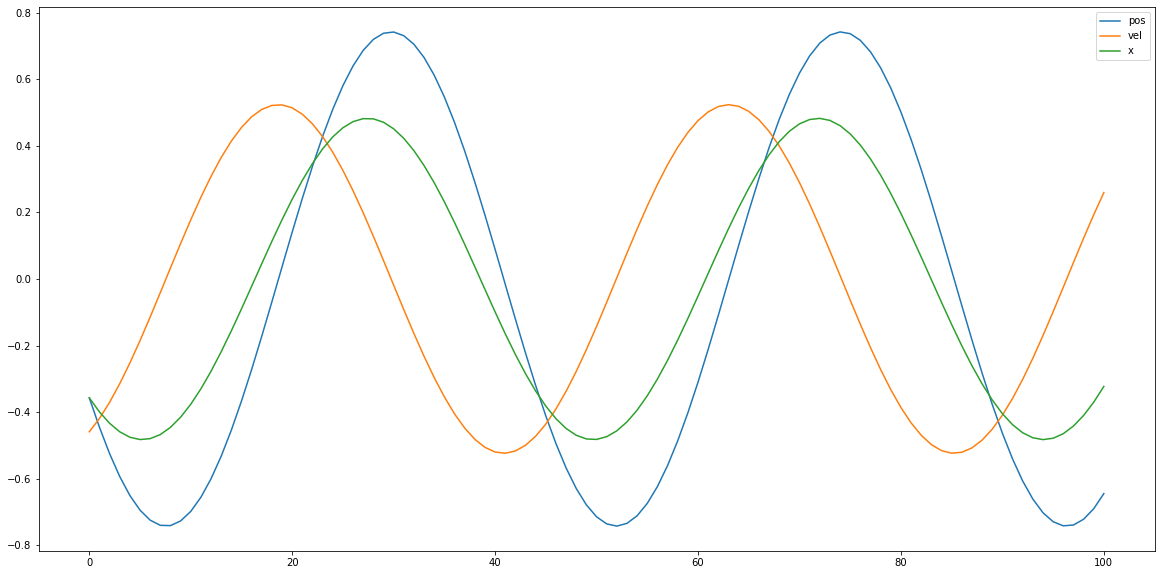

[  0.    0.1   0.2 ...  99.8  99.9 100. ]
[-0.35712408 -0.45910452]


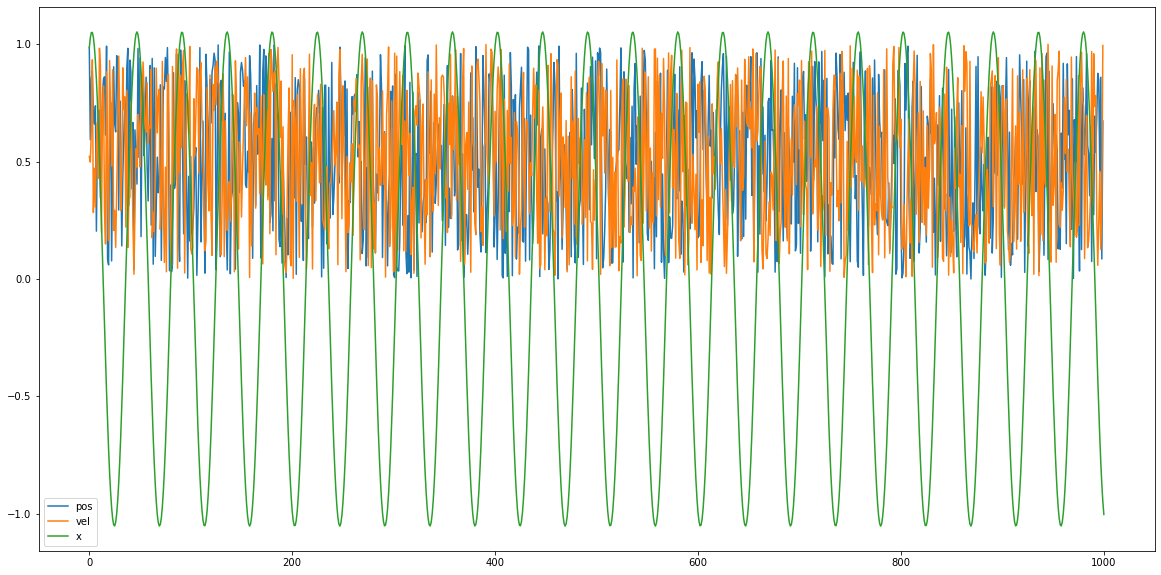

In [36]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
def x_fce(v_0, x_0, t):
    k = 1.0
    m = 0.5
    w_0 = np.sqrt(k/m)
    v_0 = v_0.reshape(-1, 1)
    x_0 = x_0.reshape(-1, 1)
    t = t.reshape(1, -1)
    return v_0 / w_0 * np.sin(w_0 * t) + x_0 * np.cos(w_0 * t)

def v_fce(v_0, x_0, t):
    k = 1.0
    m = 0.5
    w_0 = np.sqrt(k/m)
    v_0 = v_0.reshape(-1, 1)
    x_0 = x_0.reshape(-1, 1)
    t = t.reshape(1, -1)
    return v_0 * np.cos(w_0 * t) - w_0 * x_0 * np.sin(w_0 * t)


t = np.arange(0, 100+1) / 10
print(t)
print(a[0, 0, :])
x = x_fce(a[0, 0, 1], a[0, 0, 0], t)

a = np.load('dataset/spring.npy')
plt.plot(a[0, :, 0], label='pos')
plt.plot(a[0, :, 1], label='vel')

plt.plot(x.T, label='x')
plt.legend()
plt.show()

t = np.arange(0, 100+1) / 10
print(t)
print(a[0, 0, :])
x = x_fce(data[0, 0, 1], data[0, 0, 0], t)

plt.plot(data[0, :, 0], label='pos')
plt.plot(data[0, :, 1], label='vel')

plt.plot(x.T, label='x')
plt.legend()
plt.show()

In [35]:

data = np.load('results/spring/diatomic_data.npy')
print(data[0, 0, :])

[0.98548627 0.52186006]
